# Parte 2: Trabajando con el problema de arranque en frio de filtrado basado en contenido (Content-Based Filtering)

El `filtrado colaborativo` se basa en las interacciones del usuario con los items (user-item) dentro de una matriz de utilidad. El problema reside en que los nuevos usuarios o los elementos que no cuenten con interacciones registradas van a ser ignoradas por el sistema de recomendacion. A esto se le conoce como el problema de "Arranque en frio". El filtrado basado en contenido es una manera de atacar este problema al generar recomendaciones en interacciones usuario-item.

En el siguiente ejercicio, generaremos recomendaciones tipo item-item utilizando filtrado basado en contenido.

### Paso 1: Importar las librerias necesarias

Se utiizaran los siguientes paquetes de Python:

- [numpy](https://numpy.org/): para calculos cientificos
- [pandas](https://pandas.pydata.org/): para manipulacion de dato
- [scikit-learn](https://scikit-learn.org/stable/): para funciones de machine learning 
- [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/): para visualizacion de datos

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import json
import html
import re


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Paso 2: Cargando los datos

Construiremos nuestro sistema de recomendacion a partir del supuesto de que conocemos muy poco acerca de nuestros usuarios. No contamos con datos suficientes sobre las interacciones con nuestro sistema como para implementar filtrado colaborativo.

Exploremos el dataset para conocer su estructura y las propiedades con las que podemos trabajar.

In [3]:
data = open('equipo27/ratebeer.json')

fichero = []

for line in data:
    fichero.append('{"' + line.replace('"', "").replace("{", "").replace("}", "").replace("'Ni'", "Ni").replace("'Peng'", "Peng").replace("'Neee-wom'", "Neee-wom").replace("\n", "").replace("\t", " ").replace("': '", '": "').replace("', '", '", "').replace('&quot;', '').replace("\'", "").replace("\\", "").replace('/text: ', '/text": "') + '"}')

json_data = json.dumps(fichero, indent=4)

# Guardar como JSON file
with open('equipo27/clean_ratebeer.json', 'w') as json_file:
    json_file.write(json_data)

In [4]:
file = open('equipo27/clean_ratebeer.json')

file_contents = file.read()

json_data = json.loads(file_contents)

cleaned_json_strings = []
for json_str in json_data:
    json_str = re.sub(r'\\(?=")', r'\\\\', json_str)
    
    json_str = html.unescape(json_str)
    cleaned_json_strings.append(json_str)

# Parseamos los JSON strings y creamos una lista de diccionarios
data = []
for json_str in cleaned_json_strings:
    try:
        data.append(json.loads(json_str))
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        print(f"Offending string: {json_str}")


# Creamos el dataframe
df = pd.DataFrame(data)

# Visualizamos un pequeño detalle del Dataframe
print(df[:10])

df.to_csv('equipo27/ratebeer.csv', index=False)


Error parsing JSON: Expecting ':' delimiter: line 1 column 4 (char 3)
Offending string: {""}
                                  beer/name beer/beerId beer/brewerId  \
0                  John Harvards Simcoe IPA       63836          8481   
1                  John Harvards Simcoe IPA       63836          8481   
2             John Harvards Cristal Pilsner       71716          8481   
3        John Harvards Fancy Lawnmower Beer       64125          8481   
4        John Harvards Fancy Lawnmower Beer       64125          8481   
5  John Harvards Vanilla Black Velvet Stout       31544          8481   
6          John Harvards American Brown Ale       71714          8481   
7                   John Harvards Grand Cru       71719          8481   
8                   John Harvards Grand Cru       71719          8481   
9                   John Harvards Grand Cru       71719          8481   

  beer/ABV            beer/style review/appearance review/aroma review/palate  \
0      5.4  India Pale

In [2]:
df = pd.read_csv('equipo27/ratebeer.csv')

/var/folders/rj/5tnxc9fs7jv8kk0ngkbs5_z00000gp/T/ipykernel_44887/4253166023.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('equipo27/ratebeer.csv')


In [3]:
beers = df
beers.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. Ive nev..."
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured..."


Podemos ver que el dataset cuenta con el id de la cerveza, el nombre y el stylo de cerveza asociado.

### Paso 3: Limpieza y Exploracion de los Datos

Para este dataset en particular, debemos de limpiar los datos partiendo de las dos siguientes consideraciones:

1. Los estilos de las cervezas estan expresados en un string separados por una diagonal / . Debemos manipular este string en una lista que nos facilitara el analisis de los datos.
2. Las ponderaciones de la apariencia, aroma, cuerpo, sabor y resumen se encuentran en fracciones lo que debemos de convertilas.

#### Transformando los Estilos de un String a una lista


Utilizaremos la funcion "split" para separar los generos de la columna con el mismo nombre. 

Por lo que convertiremos este string:

`"Bohemian Pilsener/Klsch"`

En un arreglo como este:
`[Bohemian Pilsener, Klsch]`.

In [4]:
beers['beer/style_split'] = beers['beer/style'].apply(lambda x: x.split("/"))
beers.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,beer/style_split
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",[India Pale Ale (IPA)]
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....,[India Pale Ale (IPA)]
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. Ive nev...",[Bohemian Pilsener]
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...,[Klsch]
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",[Klsch]


#### Calculemos cuantos estilos de cervezas contiene el dataset?

Al utilizar la funcion de conteo de Python podemos crear un diccionario que contenga el conteo de frecuencias para cada estilo en el dataset.

In [5]:
from collections import Counter

contador_estilos = Counter(s for styles in beers['beer/style_split'] for s in styles)
print(f"Existen {len(contador_estilos)} estilos de cervezas.")
contador_estilos

Existen 101 estilos de cervezas.


Counter({'India Pale Ale (IPA)': 185953,
         'Bohemian Pilsener': 17477,
         'Klsch': 17502,
         'Sweet Stout': 40296,
         'Brown Ale': 66632,
         'Belgian Ale': 56122,
         'Abbey Tripel': 51955,
         'Belgian White (Witbier)': 48093,
         'Mild Ale': 13127,
         'Pale Lager': 145618,
         'Imperial': 122777,
         'Double IPA': 105672,
         'Sour Ale': 48343,
         'Wild Ale': 48343,
         'Traditional Ale': 15928,
         'Heller Bock': 24221,
         'Porter': 94514,
         'Bitter': 72470,
         'Spice': 69917,
         'Herb': 69917,
         'Vegetable': 69917,
         'Imperial Stout': 122223,
         'Belgian Strong Ale': 123946,
         'Golden Ale': 69048,
         'Blond Ale': 69048,
         'Scottish Ale': 9433,
         'Stout': 66286,
         'Scotch Ale': 26923,
         'Abbey Dubbel': 29710,
         'Saison': 41287,
         'Dunkel': 27970,
         'American Pale Ale': 101732,
         'Altbier':

#### Cuales son los generos de peliculas mas comunes?

Utilizaremos el metodo mas comun de `Counter` que es `most_common()` para obtener el listado de generos con asociados a la mayor cantidad de peliculas.

In [8]:
print("Top 11 de estilos de cervezas: \n", contador_estilos.most_common(11))

Top 11 de estilos de cervezas: 
 [('India Pale Ale (IPA)', 185953), ('Pale Lager', 145618), ('Belgian Strong Ale', 123946), ('Imperial', 122777), ('Imperial Stout', 122223), ('Double IPA', 105672), ('American Pale Ale', 101732), ('Porter', 94514), ('Barley Wine', 90233), ('Fruit Beer', 80640), ('Bitter', 72470)]


In [10]:
contador = Counter(s for style in beers['beer/style'] for s in style)
lstCommon = [item[0] for item in contador_estilos.most_common(100)]

print(lstCommon)

['India Pale Ale (IPA)', 'Pale Lager', 'Belgian Strong Ale', 'Imperial', 'Imperial Stout', 'Double IPA', 'American Pale Ale', 'Porter', 'Barley Wine', 'Fruit Beer', 'Bitter', 'Amber Ale', 'American Strong Ale', 'Spice', 'Herb', 'Vegetable', 'Golden Ale', 'Blond Ale', 'Premium Bitter', 'ESB', 'Brown Ale', 'Stout', 'German Hefeweizen', 'Belgian Ale', 'Abbey Tripel', 'Sour Ale', 'Wild Ale', 'Belgian White (Witbier)', 'Wheat Ale', 'Oktoberfest', 'Mrzen', 'Saison', 'Sweet Stout', 'English Strong Ale', 'Pilsener', 'Doppelbock', 'Dortmunder', 'Helles', 'Abbey Dubbel', 'Premium Lager', 'Classic German Pilsener', 'Dunkel', 'Scotch Ale', 'Vienna', 'Smoked', 'Heller Bock', 'Dry Stout', 'English Pale Ale', 'Schwarzbier', 'Old Ale', 'Abt', 'Quadrupel', 'Cider', 'Dunkler Bock', 'Dunkelweizen', 'Klsch', 'Bohemian Pilsener', 'Strong Porter', 'American Dark Lager', 'Strong Pale Lager', 'Imperial Pils', 'Zwickel', 'Keller', 'Landbier', 'Altbier', 'Specialty Grain', 'Traditional Ale', 'Irish Ale', 'Black

En el Top 11 de estilos que encontramos: `India Pale Ale (IPA)`, `Pale Lager`, `Belgian Strong Ale`, `Imperial`, `Imperial Stout`,`Double IPA`, `American Pale Ale`, `Porter`, `Barley Wine`, `Fruit Beer` y `Bitter`. 

Utilizemos barplot para visualizar esta informacion.

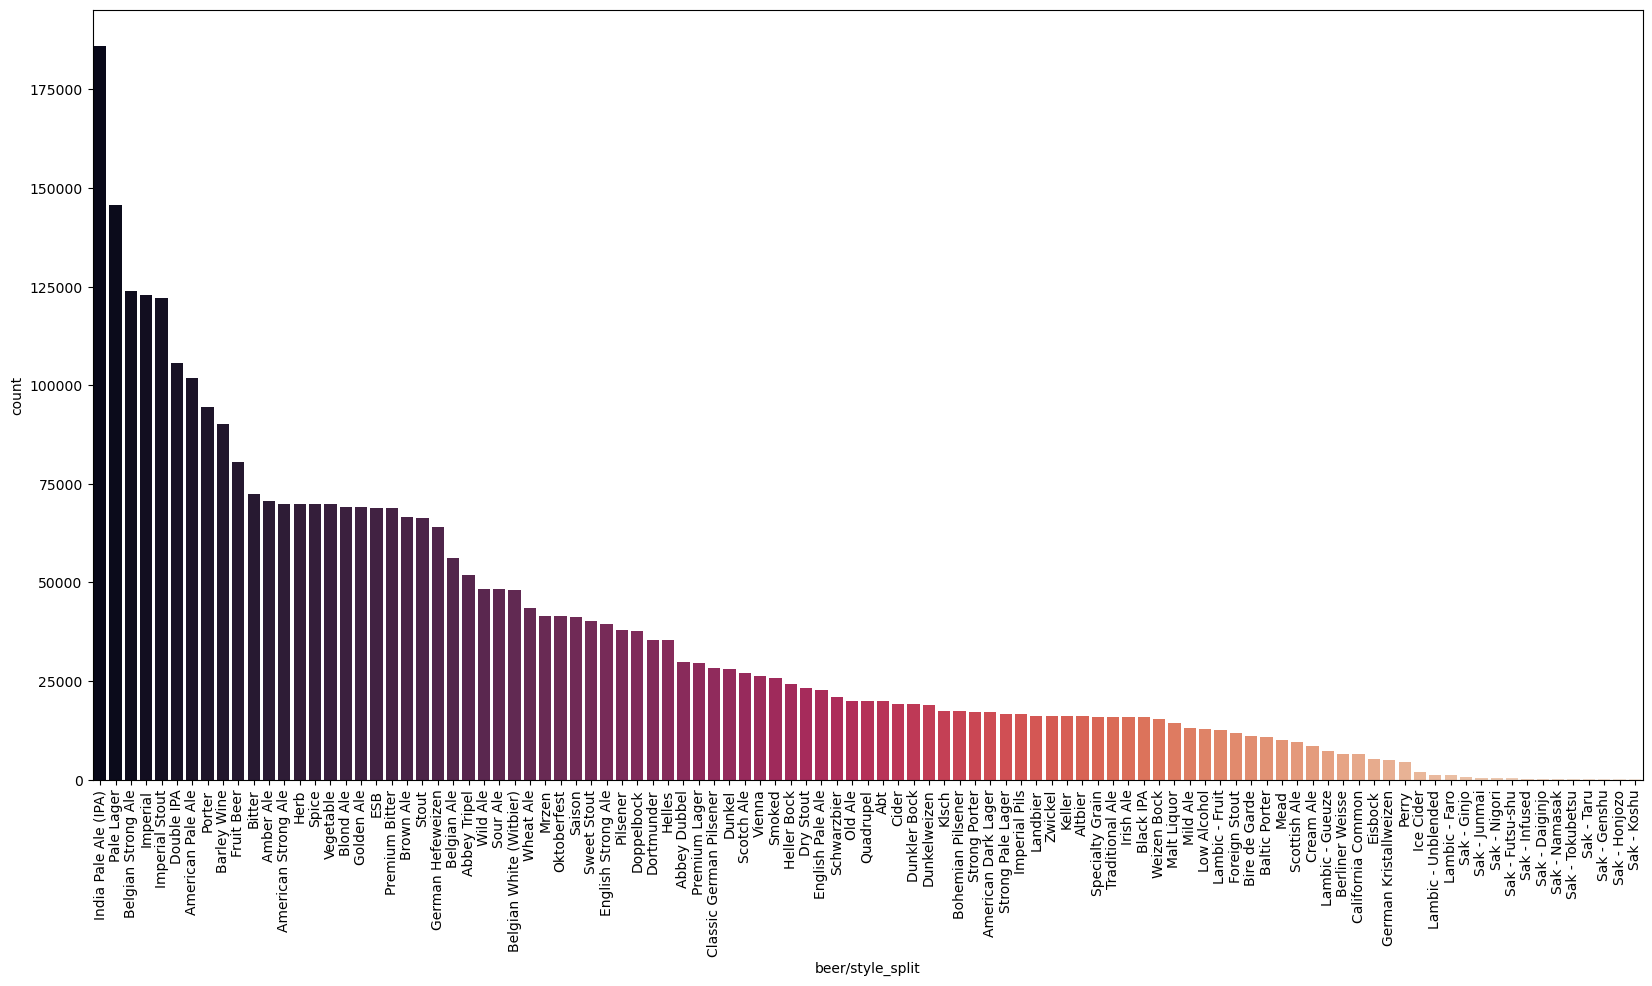

In [10]:
styles_counts_df = pd.DataFrame([contador_estilos]).T.reset_index()
styles_counts_df.columns = ['beer/style_split', 'count']
styles_counts_df = styles_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(20,10))
sns.barplot(x='beer/style_split', y='count', data=styles_counts_df, palette='rocket')
plt.xticks(rotation=90)
plt.show()

La grafica nos confirma lo que descubrimos anteriormente, `India Pale Ale (IPA)` y `Pale Lager` son los estilos mas populares mientras que los `Sak - Genshu`, `Sak - Honjozo`, y `Sak - Koshu` son los menos populares.

#### Obteniendo las calificaciones en un monto tangible

Nuestro dataset seleccionado cuenta las calificaciones con una ponderación de X / Y y esto es importante convertirlo para que podamos ponderar de mejor manera la calificiación para cada carveza y rubro. Luego entonces, se va a crear una nueva columna con el valor convertido, los nombres de las columnas serán `review/appearance_value`, `review/aroma_value`, `review/palate_value`, `review/taste_value` y `review/overall_value`.


La siguiente funcion lleva a cabo esta tarea.
`convert_to_float()` toma la ponderación y hace lo siguiente:

- Realiza un split del valor tomado (e.g., `13/20`)
- este devolverá siempre 2 valores, el numerador y el denominador
- Se los asigna a las variables num y denom
- En el return converte los valores a flotante para que nos salgan el producto decimales

In [7]:
# Definimos una función para convertir "x/y" en un número flotante
def convert_to_float(fraction):
    num, denom = fraction.split('/')
    return float(num) / float(denom)

In [8]:
# Aplicamos la función a las columnas relevantes y añadimos nuevas columnas al DataFrame
beers['review/appearance_value'] = df['review/appearance'].apply(convert_to_float)
beers['review/aroma_value'] = df['review/aroma'].apply(convert_to_float)
beers['review/palate_value'] = df['review/palate'].apply(convert_to_float)
beers['review/taste_value'] = df['review/taste'].apply(convert_to_float)
beers['review/overall_value'] = df['review/overall'].apply(convert_to_float)

In [13]:
#Realizamos un head para visualizar el dataframe y que realizará bien la conversión
beers.head()

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,beer/style_split,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",[India Pale Ale (IPA)],0.8,0.6,0.6,0.6,0.65
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....,[India Pale Ale (IPA)],0.8,0.6,0.8,0.7,0.65
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. Ive nev...",[Bohemian Pilsener],0.8,0.5,0.6,0.6,0.70
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...,[Klsch],0.4,0.4,0.4,0.4,0.40
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",[Klsch],0.4,0.4,0.4,0.4,0.40


In [9]:
# Convertimos el valor '-' a cero y la columna en flotante
beers['beer/ABV_value'] = df['beer/ABV'].str.replace('-', '0').astype(float).round(0)

In [15]:
n_abv = beers['beer/ABV'].nunique()
print(f"Total unicos de grados de alcohol: {n_abv}")

Total unicos de grados de alcohol: 610


In [16]:
n_abv_val = beers['beer/ABV_value'].nunique()
print(f"Total unicos de grados de alcohol: {n_abv_val}")

Total unicos de grados de alcohol: 33


#### Si bien no contamos con el nombre de la cervecera, podemos obtener cuantas distintas cerveceras estan contenidos en nuestro dataset?


In [17]:
n_brewers = beers['beer/brewerId'].nunique()
print(f"Total unicos de cerverías: {n_brewers}")

Total unicos de cerverías: 7547


In [18]:
print(f"Numero total de cervezas en el dataset: {beers['beer/beerId'].nunique()}")

Numero total de cervezas en el dataset: 110647


#### Cual fue la cerveza con el grado de alochol más bajo de la lista?

In [19]:
abv_media = beers.groupby('beer/beerId')[['beer/ABV_value']].mean()
print(f"Cerveza con el menor grado de alcohol")
menor_grado = abv_media['beer/ABV_value'].idxmin()
beers.loc[beers['beer/beerId'] == menor_grado]

Cerveza con el menor grado de alcohol


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,beer/style_split,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value,beer/ABV_value
1948455,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,3/5,3/10,3/5,5/10,8/20,1301702400,DiarmaidBHK,Its mild and inoffensive which is to say its n...,"[Golden Ale, Blond Ale]",0.6,0.3,0.6,0.5,0.40,0.0
1948456,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,2/5,3/10,2/5,3/10,7/20,1231286400,biznizness,Had these beer at the brewpub with my dad on o...,"[Golden Ale, Blond Ale]",0.4,0.3,0.4,0.3,0.35,0.0
1948457,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,1/5,2/10,1/5,4/10,6/20,1219449600,Guinness4Duff,On tap at Barley Creek. Clear light straw col...,"[Golden Ale, Blond Ale]",0.2,0.2,0.2,0.4,0.30,0.0
1948458,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,1/5,1/10,1/5,1/10,1/20,1207526400,Prostman,This was the lightest looking beer I have ever...,"[Golden Ale, Blond Ale]",0.2,0.1,0.2,0.1,0.05,0.0
1948459,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,1/5,1/10,1/5,1/10,2/20,1201478400,bigrond,this is one of the worst beers Ive ever had. ...,"[Golden Ale, Blond Ale]",0.2,0.1,0.2,0.1,0.10,0.0
1948460,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,1/5,3/10,1/5,2/10,3/20,1195862400,grandet,5 oz sample. Terrible. Tasted like hop water. ...,"[Golden Ale, Blond Ale]",0.2,0.3,0.2,0.2,0.15,0.0
1948461,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,2/5,2/10,3/5,4/10,7/20,1191888000,argo0,(draft) Lightly hazed pear juice with white he...,"[Golden Ale, Blond Ale]",0.4,0.2,0.6,0.4,0.35,0.0
1948462,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,1/5,2/10,3/5,3/10,4/20,1186790400,jkoch,Very light yellow witha small white head. No...,"[Golden Ale, Blond Ale]",0.2,0.2,0.6,0.3,0.20,0.0
1948463,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,2/5,3/10,2/5,3/10,6/20,1182988800,hopdog,On tap at the Barley Creek Brew Pub (listed as...,"[Golden Ale, Blond Ale]",0.4,0.3,0.4,0.3,0.30,0.0
1948464,Barley Creek Cliffhanger Light Ale,21,6,-,Golden Ale/Blond Ale,2/5,5/10,2/5,4/10,8/20,1177113600,hophead75,light gold in color. Not much of anything in ...,"[Golden Ale, Blond Ale]",0.4,0.5,0.4,0.4,0.40,0.0


#### Cual fue la cerveza con el mayo grado de alochol de la lista?

In [20]:
mayor_grado = abv_media['beer/ABV_value'].idxmax()
print(f"Cerveza con el mayor grado de alcohol")
beers.loc[beers['beer/beerId'] == mayor_grado]

Cerveza con el mayor grado de alcohol


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,beer/style_split,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value,beer/ABV_value
443245,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,3/5,5/10,2/5,3/10,9/20,1324684800,omhper,"Bottled, thanks ZWR! Viscous brownish amber, ...",[Eisbock],0.6,0.5,0.4,0.3,0.45,58.0
443246,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,4/5,2/10,2/5,1/10,1/20,1323648000,MiP,"Bottle, 57%. The aroma is vinous and boozy at ...",[Eisbock],0.8,0.2,0.4,0.1,0.05,58.0
443247,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,3/5,3/10,2/5,3/10,5/20,1321315200,Theis,Bottle at Papss - Thanks (Yespr). Clear amber/...,[Eisbock],0.6,0.3,0.4,0.3,0.25,58.0
443248,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,2/5,7/10,3/5,7/10,10/20,1321142400,fonefan,Bottle 330ml. w. swing top. [ Bottle # 1 / 36 ...,[Eisbock],0.4,0.7,0.6,0.7,0.50,58.0
443249,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,3/5,7/10,2/5,6/10,12/20,1320105600,joergen,Ceramic bottle at Paps.tClear orange red colou...,[Eisbock],0.6,0.7,0.4,0.6,0.60,58.0
443250,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,2/5,4/10,3/5,7/10,14/20,1320019200,Pinball,"bottle at papsoe tasting, shared by yespr, tha...",[Eisbock],0.4,0.4,0.6,0.7,0.70,58.0
443251,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,4/5,7/10,5/5,5/10,11/20,1320019200,Ungstrup,Bottled. An amber beer with no head. The aroma...,[Eisbock],0.8,0.7,1.0,0.5,0.55,58.0
443252,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,3/5,6/10,3/5,6/10,11/20,1320019200,yespr,"33 cL ceramic bottle, #1 of 36, courtesy of ka...",[Eisbock],0.6,0.6,0.6,0.6,0.55,58.0
443253,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,2/5,3/10,2/5,4/10,6/20,1320019200,madsberg,Bottled 1 of 36. Amber colorued. No head. Arom...,[Eisbock],0.4,0.3,0.4,0.4,0.30,58.0
443254,Schorschbru Schorschbock 57% finis coronat opus,154245,1506,57.7,Eisbock,3/5,7/10,3/5,7/10,14/20,1320019200,Papsoe,Ceramic bottle 33 cl. Courtesy of yespr. Bottl...,[Eisbock],0.6,0.7,0.6,0.7,0.70,58.0


#### Cual fue la cerveza con el peor sabor de la lista?

In [21]:
taste_media = beers.groupby('beer/beerId')[['review/taste_value']].mean()
print(f"Cerveza con el peor sabor")
taste_malo = taste_media['review/taste_value'].idxmin()
beers.loc[beers['beer/beerId'] == taste_malo]

Cerveza con el peor sabor


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,beer/style_split,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value,beer/ABV_value
1857657,American Originals Faust Golden Lager,490,84,-,Pale Lager,1/5,1/10,1/5,1/10,1/20,1219449600,Artillery,This is bad I dont know how else you could say...,[Pale Lager],0.2,0.1,0.2,0.1,0.05,0.0
1857658,American Originals Faust Golden Lager,490,84,-,Pale Lager,1/5,1/10,1/5,1/10,1/20,1089072000,REDDOGICE,"Why god WHY did this shit end up in m,y refrid...",[Pale Lager],0.2,0.1,0.2,0.1,0.05,0.0
1857659,American Originals Faust Golden Lager,490,84,-,Pale Lager,1/5,1/10,1/5,1/10,1/20,1038614400,Supaflyfresh99,Why oh why did I ever buy this beer? I think i...,[Pale Lager],0.2,0.1,0.2,0.1,0.05,0.0
1857660,American Originals Faust Golden Lager,490,84,-,Pale Lager,1/5,1/10,1/5,1/10,1/20,1013299200,MaxPower,A.B. Brews are overpriced I cant believe anone...,[Pale Lager],0.2,0.1,0.2,0.1,0.05,0.0


#### Cual fue la cerveza con el mejor sabor de toda la lista?

In [22]:
taste_alto = taste_media['review/taste_value'].idxmax()
print(f"Cerveza con el mejor sabor")
beers.loc[beers['beer/beerId'] == taste_alto]

Cerveza con el mejor sabor


,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,beer/style_split,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value,beer/ABV_value
1436186,Golden Pacific Black Bear Dry Stout,809,127,4,Stout,5/5,9/10,5/5,10/10,18/20,1029024000,DocKozzak99,Good ooking & tasting stout! Slight aftertaste...,[Stout],1.0,0.9,1.0,1.0,0.9,4.0


### Paso 4: Transformando los datos

Para construir un sistema de recomendacion con filtrado basado en contenido necesitamos preparar nuestro dataset de forma tal que las filas representen las cervezas y las columnas las caracteristicas (estilo y grado de alcohol)


Primero, debemos manipular la columna de `beer/style` de forma tal que cada genero sea representado por una caracteristica binaria (1 si pertenece a un determinado genero, 0 si no pertenece)

In [11]:
beers_filter = beers[beers['beer/style'].isin(lstCommon)]
beers_filter

,beer/name,beer/beerId,beer/brewerId,beer/ABV,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall,review/time,review/profileName,review/text,beer/style_split,review/appearance_value,review/aroma_value,review/palate_value,review/taste_value,review/overall_value,beer/ABV_value
0,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,3/5,6/10,13/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",[India Pale Ale (IPA)],0.8,0.6,0.6,0.6,0.65,5.0
1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),4/5,6/10,4/5,7/10,13/20,1157241600,TomDecapolis,On tap at the John Harvards in Springfield PA....,[India Pale Ale (IPA)],0.8,0.6,0.8,0.7,0.65,5.0
2,John Harvards Cristal Pilsner,71716,8481,5,Bohemian Pilsener,4/5,5/10,3/5,6/10,14/20,958694400,PhillyBeer2112,"UPDATED: FEB 19, 2003 Springfield, PA. Ive nev...",[Bohemian Pilsener],0.8,0.5,0.6,0.6,0.70,5.0
3,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,TomDecapolis,On tap the Springfield PA location billed as t...,[Klsch],0.4,0.4,0.4,0.4,0.40,5.0
4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,2/5,4/10,2/5,4/10,8/20,1157587200,hopdog,"On tap at the Springfield, PA location. Poured...",[Klsch],0.4,0.4,0.4,0.4,0.40,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924154,Oakhill Mendip Twister,12240,1028,6.3,Stout,4/5,8/10,4/5,7/10,17/20,1140048000,DJMonarch,Bottle 16/08/2004tBlack rich on the palate and...,[Stout],0.8,0.8,0.8,0.7,0.85,6.0
2924155,Oakhill Mendip Twister,12240,1028,6.3,Stout,3/5,3/10,3/5,4/10,8/20,1064188800,imdownthepub,"Bottled, Pasteurised. A dark brown beer with l...",[Stout],0.6,0.3,0.6,0.4,0.40,6.0
2924156,Oakhill Mendip Twister,12240,1028,6.3,Stout,3/5,6/10,2/5,6/10,10/20,1019520000,OlJuntan64,"Dark brown, complex strong malt, faint coffe a...",[Stout],0.6,0.6,0.4,0.6,0.50,6.0
2924157,Oakhill Mendip Twister,12240,1028,6.3,Stout,2/5,5/10,2/5,5/10,8/20,1019433600,Kst,"Burnt suggar, molasses.Smells coffie. OK in sm...",[Stout],0.4,0.5,0.4,0.5,0.40,6.0


In [12]:
styles = list(contador_estilos.keys())

for s in lstCommon:
    beers_filter[s] = beers_filter['beer/style'].transform(lambda x: int(s in x))

/var/folders/rj/5tnxc9fs7jv8kk0ngkbs5_z00000gp/T/ipykernel_44887/1872771827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beers_filter[s] = beers_filter['beer/style'].transform(lambda x: int(s in x))
/var/folders/rj/5tnxc9fs7jv8kk0ngkbs5_z00000gp/T/ipykernel_44887/1872771827.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beers_filter[s] = beers_filter['beer/style'].transform(lambda x: int(s in x))
/var/folders/rj/5tnxc9fs7jv8kk0ngkbs5_z00000gp/T/ipykernel_44887/1872771827.py:4: SettingWithCopyWar

Analizando la estructura de los datos se desplieguan de la siguiente manera:

In [13]:
beers_filter[lstCommon].head()

,India Pale Ale (IPA),Pale Lager,Belgian Strong Ale,Imperial,Imperial Stout,Double IPA,American Pale Ale,Porter,Barley Wine,Fruit Beer,...,Sak - Junmai,Sak - Nigori,Sak - Futsu-shu,Sak - Infused,Sak - Daiginjo,Sak - Namasak,Sak - Tokubetsu,Sak - Taru,Sak - Genshu,Sak - Honjozo
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Con esto comprobamos que los estilos se representan como columnas con propiedades binarias. Ahora debemos asignar los distintos grados de alcohol a sus columnas correspondientes. Lo realizamos al utilizar la funcion `get_dummies()` de `pandas` al crear variables categoricas en variables binarias.

In [14]:
beer_ABV = pd.get_dummies(beers_filter['beer/ABV_value'])
beer_ABV.head()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,23.0,25.0,26.0,27.0,28.0,29.0,31.0,39.0,43.0,58.0
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Lo siguiente es crear un nuevo dataframe con las propiedades del grado de alcohol y el estilo de las cervezas en `beer_features`. Lo conseguimos al utilizar la funcion `concat` de pandas, al concatenar los generos y las decadas en un solo dataframe.

In [15]:
beer_features = pd.concat([beers_filter[lstCommon], beer_ABV], axis=1)
beer_features.head()

,India Pale Ale (IPA),Pale Lager,Belgian Strong Ale,Imperial,Imperial Stout,Double IPA,American Pale Ale,Porter,Barley Wine,Fruit Beer,...,23.0,25.0,26.0,27.0,28.0,29.0,31.0,39.0,43.0,58.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
total_nulls = beer_features.isnull().sum().sum()

# Verificar si hay algún valor nulo
if total_nulls > 0:
    print("Hay valores nulos en el DataFrame.")
else:
    print("No hay valores nulos en el DataFrame.")


No hay valores nulos en el DataFrame.


In [17]:
beer_features.duplicated().sum()

2412894

In [18]:
b_features = beer_features.copy()
b_features.drop_duplicates()

,India Pale Ale (IPA),Pale Lager,Belgian Strong Ale,Imperial,Imperial Stout,Double IPA,American Pale Ale,Porter,Barley Wine,Fruit Beer,...,23.0,25.0,26.0,27.0,28.0,29.0,31.0,39.0,43.0,58.0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2861349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2879154,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2881023,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
del df

import gc
gc.collect()

0

In [19]:
b_features.to_csv('equipo27/beer_features.csv', index=False)

In [20]:
import pandas as pd

bf = pd.read_csv('equipo27/beer_features.csv')
beer_f = bf.drop_duplicates()
beer_f.shape

(774, 133)

El dataframe `beer_features` esta listo y contiene los datos que nos interesan. Ahora debemos de construir nuestro sistema de recomendacion.

### Step 5: Construyendo un sistema de recomendacion de "Cervezas Parecidas" utilizando similitud Coseno

Para construir este sistema de recomendacion item-item utilizaremos una metrica llamada similitud coseno `cosine similarity`.

La similitud Coseno se basa en el coseno del angulo entre dos vectores (c.e., $A$ y $B$). Entre mas pequeño es el angulo, mayor es la similitud entre los vectores, y se calcula de la siguiente forma:

$$\cos(\theta) = \frac{A\cdot B}{||A|| ||B||}$$

En este ejercicio, utilizaremos la funcion de scikit-learn de `cosine_similarity` para generar la matriz de similitud de tipo $(n_{\text{beers}}, n_{\text{beers}})$. Esta matriz nos permitira extraer peliculas que sean parecidas a nuestra pelicula de interes.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(beer_f, beer_f)
print(f"Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: {cosine_sim.shape}")

Las dimensiones de similaridad coseno de las caracteristicas de nuestra matriz de similitud son: (774, 774)


Esto nos indica que al evaluar la similitud de coseno del dataframe `beer_features` en la funcion `cosine_similarity()` obtenemos una matriz de similitud del tipo $(n_{\text{beers}}, n_{\text{beers}})$.

Esta matriz contiene valores entre 0 y 1 que representan el angulo de similaridad entre las peliculas en los ejes x , y.


### Desarrollando una funcion que encuentre cervezas similares

Deseamos encontrar el indice de la cerveza en la matriz de similitud coseno. Para identificar la fila en la cual debemos buscar podemos crear un mapeador de indices de cervezas que encuentre el nombre de una cerveza y le asigne el indice que representa en nuestra matriz.

Crearemos un diccionario llamado `beer_idx` donde las llaves son los nombres de las cervezas y los valores son los indices de las cervezas.

In [28]:
from fuzzywuzzy import process

def encuentra_cerveza(title):
    all_titles = beers['beer/name'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [30]:
title = encuentra_cerveza('Jon Harvads Simco IPA')
print(f"El nombre correcto de la cerveza es: {title}")

El nombre correcto de la cerveza es: John Harvards Simcoe IPA


In [38]:
#listBeerNames = list(set(beers['beer/name']))

beer_idx = dict(zip(beers['beer/name'], list(beers.index)))
idx = beer_idx[title]
print(f"El indice de la cerveza {title} en la matriz beer_idx es: {idx}")

El indice de la cerveza John Harvards Simcoe IPA en la matriz beer_idx es: 1


Al usar el diccionario `beer_idx`, sabemos que Jon Harvads Simco IPA se representa por el indice 1 en nuestra matriz. 

Ahora tratemos de encontrar las 10 cervezas mas similares a la John Harvards Simcoe IPA.

In [39]:
numero_recomendaciones = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(numero_recomendaciones+1)]
similar_beers = [i[0] for i in sim_scores]

`similar_movies` es un arreglo de indices que representa el top 10 de recomendaciones a partir de la pelicula elegida (en este caso Jumanji). Podemos encontrar el titulos de las peliculas correspondientes al crear un mapeador invertido de `movie_idx` o usando `iloc` en la columna de titulo del dataframe `movies`.

In [40]:
print(f"Por que bebiste la cerveza {title}, te pueden interesar las siguientes {numero_recomendaciones} cervezas:")
beers['beer/name'].iloc[similar_beers]

Por que bebiste la cerveza John Harvards Simcoe IPA, te pueden interesar las siguientes 10 cervezas:


45     Barley Island Sinister Minister Belgian Black Ale
88     Barley Island Sinister Minister Belgian Black Ale
135                             Barley Island Barfly IPA
150                             Barley Island Barfly IPA
350                  Barley Island Dirty Helen Brown Ale
561           Barley Island Brass Knuckles Oatmeal Stout
576              Barley Island Count Hopula Imperial IPA
631                   Barley Island Beastie Barrel Stout
0                               John Harvards Simcoe IPA
2                          John Harvards Cristal Pilsner
Name: beer/name, dtype: object

Podemos probar nuestro sistema con otros titulos de peliculas. 

In [45]:
def obtener_recomendaciones_basadas_contenido(title_string, numero_recomendaciones=10):
    title = encuentra_cerveza(title_string)
    idx = beer_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(numero_recomendaciones+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Las cervezas recomendadas con base en la cerveza {title} son:")
    print(beers['beer/name'].iloc[similar_movies])

In [46]:
obtener_recomendaciones_basadas_contenido('Barley Island Barfly IPA', 8)

Las cervezas recomendadas con base en la cerveza Barley Island Barfly IPA son:
6                      John Harvards American Brown Ale
34               Barley Island Dirty Old Helen Sour Ale
48    Barley Island Sinister Minister Belgian Black Ale
49    Barley Island Sinister Minister Belgian Black Ale
55    Barley Island Sinister Minister Belgian Black Ale
64    Barley Island Sinister Minister Belgian Black Ale
70    Barley Island Sinister Minister Belgian Black Ale
75    Barley Island Sinister Minister Belgian Black Ale
Name: beer/name, dtype: object


### Step 6: Construyendo un sistema de recomendacion de "Cervezas Parecidas" utilizando distancia aucladiana

In [23]:
from sklearn.metrics.pairwise import euclidean_distances

euclidean_dis = euclidean_distances(beer_f, beer_f)
print(f"Las dimensiones de distancia Euclidiana de las caracteristicas de nuestra matriz de similitud son: {euclidean_dis.shape}")

Las dimensiones de distancia Euclidiana de las caracteristicas de nuestra matriz de similitud son: (774, 774)


In [47]:
numero_recomendaciones = 10
dis_scores = list(enumerate(euclidean_dis[idx]))
dis_scores = sorted(dis_scores, key=lambda x: x[1], reverse=True)
dis_scores = dis_scores[1:(numero_recomendaciones+1)]
sim_beers = [i[0] for i in dis_scores]

In [48]:
print(f"Por que bebiste la cerveza {title}, te pueden interesar las siguientes {numero_recomendaciones} cervezas:")
beers['beer/name'].iloc[sim_beers]

Por que bebiste la cerveza John Harvards Simcoe IPA, te pueden interesar las siguientes 10 cervezas:


26     Barley Island Dirty Old Helen Sour Ale
190                  Barley Island Barfly IPA
197                  Barley Island Barfly IPA
215                  Barley Island Barfly IPA
242                  Barley Island Barfly IPA
281                  Barley Island Barfly IPA
347       Barley Island Dirty Helen Brown Ale
363       Barley Island Dirty Helen Brown Ale
380       Barley Island Dirty Helen Brown Ale
396       Barley Island Dirty Helen Brown Ale
Name: beer/name, dtype: object

In [49]:
def obtener_recomendaciones_basadas_distancia(title_string, numero_recomendaciones=10):
    title = encuentra_cerveza(title_string)
    idx = beer_idx[title]
    dis_scores = list(enumerate(euclidean_dis[idx]))
    dis_scores = sorted(dis_scores, key=lambda x: x[1], reverse=True)
    dis_scores = dis_scores[1:(numero_recomendaciones+1)]
    sim_beers = [i[0] for i in dis_scores]
    print(f"Las cervezas recomendadas con base en la cerveza {title} son:")
    print(beers['beer/name'].iloc[sim_beers])

In [56]:
#listBeerNames = list(set(beers['beer/name']))
name = encuentra_cerveza('John Harvards Yin Yang Lager')
beer_idx = dict(zip(beers['beer/name'], range(1, len(df) + 1)))
idx = beer_idx[name]
print(f"El indice de la cerveza {title} en la matriz beer_idx es: {idx}")

El indice de la cerveza John Harvards Simcoe IPA en la matriz beer_idx es: 15


In [58]:
obtener_recomendaciones_basadas_distancia('Barley Island Goldilocks Belgian Blond', 8)

Las cervezas recomendadas con base en la cerveza Barley Island Goldilocks Belgian Blond son:
190               Barley Island Barfly IPA
197               Barley Island Barfly IPA
215               Barley Island Barfly IPA
242               Barley Island Barfly IPA
281               Barley Island Barfly IPA
347    Barley Island Dirty Helen Brown Ale
363    Barley Island Dirty Helen Brown Ale
380    Barley Island Dirty Helen Brown Ale
Name: beer/name, dtype: object
